# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
import datetime
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler



% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Analyse and clean portfolio dataset

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.shape

(10, 6)

(array([ 2.,  0.,  2.,  1.,  0.,  3.,  0.,  0.,  0.,  2.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 <a list of 10 Patch objects>)

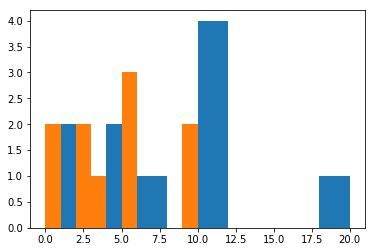

In [4]:
plt.hist(portfolio['difficulty'])
plt.hist(portfolio['reward'])

(array([ 4.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  2.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

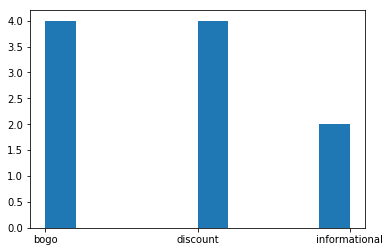

In [5]:
plt.hist(portfolio['offer_type'])

In [6]:
#Check for NaNs
print('Natrurally missing data points {}'.format(portfolio.isnull().sum()))

Natrurally missing data points channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64


In [7]:
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

In [8]:
def clean_portfolio_df (df):
    '''
    Input - Portfolio dataframe
    Output - Cleaned Portfolio dataframe
    '''

    #text to columns tool to convert channels column
    mlb = MultiLabelBinarizer()
    mlb.fit(df['channels'])

    df1 =\
     pd.DataFrame(mlb.transform(df['channels']),
     columns=mlb.classes_)

    del df['channels']
    portfolio_final = df.join(df1)

    #Alter column names
    portfolio_final.rename(columns={'id':'offer_id',
                          'offer_type_bogo':'bogo',
                          'offer_type_discount':'discount',
                          'offer_type_informational':'informational',}, 
                 inplace=True)
    
   
    
    
    return portfolio_final

In [9]:
portfolio_final = clean_portfolio_df(portfolio)

In [10]:
portfolio_final.head(30)

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


## Analyse and clean profile dataset

In [11]:
profile.shape

(17000, 5)

Text(0,0.5,'Frequency')

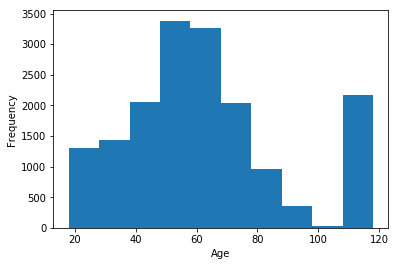

In [12]:
plt.hist(profile['age'])
plt.xlabel('Age')
plt.ylabel('Frequency')

In [13]:
profile['age'].describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [14]:
#Check for NaNs
print('Natrurally missing data points {}'.format(profile.isnull().sum()))

Natrurally missing data points age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64


In [15]:
profile['became_member_on'].describe()

count    1.700000e+04
mean     2.016703e+07
std      1.167750e+04
min      2.013073e+07
25%      2.016053e+07
50%      2.017080e+07
75%      2.017123e+07
max      2.018073e+07
Name: became_member_on, dtype: float64

In [16]:
def clean_profile_df (df):
    '''
    Input - Profile dataframe
    Output - Cleaned Profile dataframe
    '''

    profile = df
    #Convert became_member_on to member years
    datetimeFormat = '%Y%m%d'
    today = '20191107'

    years_as_member = []
    for index, row in profile.iterrows():
    
        years = datetime.datetime.strptime(today, datetimeFormat)\
        - datetime.datetime.strptime(str(row['became_member_on']), datetimeFormat)
        years = years.days/365
    
        years_as_member.append(years)
        
    member_years = pd.DataFrame(years_as_member, columns = ['member_years'])
    profile = profile.join(member_years)
    profile = profile.drop(['became_member_on'], axis=1)
    
    #Alter column names
    profile.rename(columns={'id':'member id'}, inplace=True)

    #Drop NaN rows
    profile_final = profile.dropna()
    


    
    
    return profile_final

In [17]:
profile_final = clean_profile_df(profile)



In [18]:
profile_final.head()

,age,gender,member id,income,member_years
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2.315068
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2.498630
5,68,M,e2127556f4f64592b11af22de27a7932,70000.0,1.534247
8,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,1.742466
12,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1.989041


In [19]:
print(profile.shape)
print(profile_final.shape)

(17000, 5)
(14825, 5)


## Analyze and clean transcript data

In [20]:
transcript.tail(15)

,event,person,time,value
306519,transaction,f1b31d07b5d84f69a2d5f1d07843989e,714,{'amount': 31.13}
306520,transaction,2ce987015ec0404a97ba333e8e814090,714,{'amount': 1.6400000000000001}
306521,transaction,2e33545f0a764d27b2ccff95fc8d72c4,714,{'amount': 17.35}
306522,transaction,d1c4500ace2e45e9a45d3cd2fccac8d8,714,{'amount': 4.42}
306523,transaction,b65affd9e07346a1906364a396950e3d,714,{'amount': 18.35}
306524,transaction,d613ca9c59dd42f497bdbf6178da54a7,714,{'amount': 25.14}
306525,transaction,eec70ab28af74a22a4aeb889c0317944,714,{'amount': 43.58}
306526,transaction,24f56b5e1849462093931b164eb803b5,714,{'amount': 22.64}
306527,offer completed,24f56b5e1849462093931b164eb803b5,714,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
306528,transaction,5ca2620962114246ab218fc648eb3934,714,{'amount': 2.2}


In [21]:
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [22]:
def clean_transcript_df (df):
    keys = []
    for index, row in transcript.iterrows():
        for k in row['value']:
            if k in keys:
                continue
            else:
                keys.append(k)

    transcript['offer_id'] = ''
    transcript['amount'] = 0
    transcript['reward'] = 0

    for index, row in transcript.iterrows():
        for k in row['value']:
            if k == 'offer_id' or k == 'offer id':
                transcript.at[index, 'offer_id']= row['value'][k]
            if k == 'amount':
                transcript.at[index, 'amount']= row['value'][k]
            if k == 'reward':
                transcript.at[index, 'reward']= row['value'][k]
    
    transcript_final = transcript.drop(['value'], axis = 1)
    transcript_final.rename(columns={'person':'member id'}, inplace=True)
    
    return transcript_final

In [23]:
transcript_final = clean_transcript_df(transcript)

In [24]:
transcript_final.head(10)

,event,member id,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,0
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
9,offer received,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0


In [25]:
print(transcript.shape)
print(transcript_final.shape)

(306534, 7)
(306534, 6)


## Taking a look at transcript_final dataframe

(array([ 35540.,  13961.,  35789.,  17345.,  32589.,  42039.,  24307.,
         43552.,  44593.,  16819.]),
 array([   0. ,   71.4,  142.8,  214.2,  285.6,  357. ,  428.4,  499.8,
         571.2,  642.6,  714. ]),
 <a list of 10 Patch objects>)

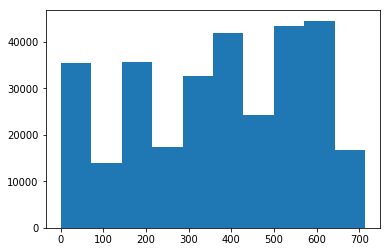

In [26]:
plt.hist(transcript_final['time'])

In [27]:
#Breakdown of Events
event_counts = transcript_final['event'].value_counts()
event_counts = pd.DataFrame(list(zip(event_counts.index.values, event_counts)),
                            columns=['event', 'count'])
event_counts

,event,count
0,transaction,138953
1,offer received,76277
2,offer viewed,57725
3,offer completed,33579


Text(0.5,1,'Informational offer 5a8bc65990b245e5a138643cd4eb9837')

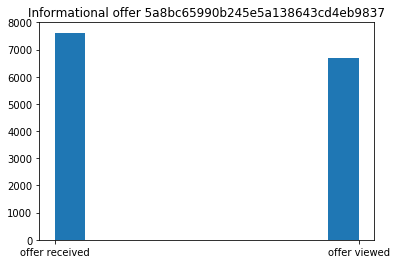

In [28]:
#Offer breakdown of events - informational offer
informational1 =  transcript_final['offer_id']=='5a8bc65990b245e5a138643cd4eb9837'
informational1 = transcript_final[informational1]
plt.hist(informational1['event'])
plt.title('Informational offer 5a8bc65990b245e5a138643cd4eb9837')

(array([ 7617.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4144.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

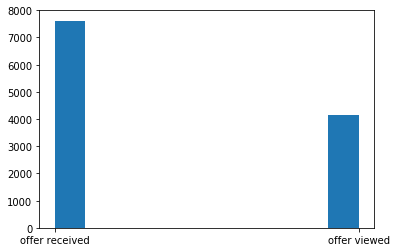

In [29]:
#Offer breakdown of events - informational offer
informational2 =  transcript['offer_id']=='3f207df678b143eea3cee63160fa8bed'
informational2 = transcript[informational2]
plt.hist(informational2['event'])

Because the informational offers do not have a "offer completed" event, I will need to try to make an assumption that any transaction that occured in the duration period after the informational offer will be considered an offer completed. 

(array([ 3688.,     0.,     0.,     0.,     0.,  7658.,     0.,     0.,
            0.,  6716.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

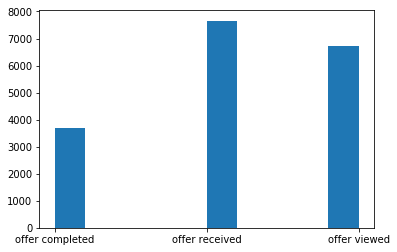

In [30]:
#Offer breakdown of events - bogo offer
bogo =  transcript['offer_id']=='ae264e3637204a6fb9bb56bc8210ddfd'
bogo = transcript[bogo]
plt.hist(bogo['event'])

In [31]:
#looking at a specific customers event history
customer =  transcript_final['member id']=='aa4862eba776480b8bb9c68455b8c2e1'
customer = transcript_final[customer]
customer.head(50)

,event,member id,time,offer_id,amount,reward
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
20284,offer viewed,aa4862eba776480b8bb9c68455b8c2e1,18,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
53183,offer received,aa4862eba776480b8bb9c68455b8c2e1,168,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
65845,offer viewed,aa4862eba776480b8bb9c68455b8c2e1,168,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
83400,transaction,aa4862eba776480b8bb9c68455b8c2e1,210,,12,0
83401,offer completed,aa4862eba776480b8bb9c68455b8c2e1,210,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10
110836,offer received,aa4862eba776480b8bb9c68455b8c2e1,336,5a8bc65990b245e5a138643cd4eb9837,0,0
123541,offer viewed,aa4862eba776480b8bb9c68455b8c2e1,336,5a8bc65990b245e5a138643cd4eb9837,0,0
150604,offer received,aa4862eba776480b8bb9c68455b8c2e1,408,ae264e3637204a6fb9bb56bc8210ddfd,0,0
174355,transaction,aa4862eba776480b8bb9c68455b8c2e1,426,,15,0


### After looking at the transcript_final data there are a few more changes that need to be made
    - Add transactions related to informational offers to offers completed based on duration time period
    - Add amount to offers completed
    - Create a new event that shows offers completed but not viewed
    - Filter dataframe to the final event of an offer life-cycle. (ie if there is an offer completed, remove the offer recieved and offer viewed since that is repetative information). 

# Add transactions related to Info Offers to offers completed

In [32]:
#Filtering the transcript_final down to the two informational offers, view events
offer_view =  transcript_final['event']=='offer viewed' 
offer_view  = transcript_final[offer_view]

info1view =  offer_view['offer_id']=='3f207df678b143eea3cee63160fa8bed' 
info1view  = offer_view[info1view]

info2view = offer_view['offer_id']=='5a8bc65990b245e5a138643cd4eb9837'
info2view = offer_view[info2view]

info_offer_view = info1view.append(info2view)

info_offer_view.head()

,event,member id,time,offer_id,amount,reward
12712,offer viewed,5749731ed31948abb540a956963926ba,0,3f207df678b143eea3cee63160fa8bed,0,0
12722,offer viewed,fc41f98eaccc4c6e9ba3d3361714c527,0,3f207df678b143eea3cee63160fa8bed,0,0
12732,offer viewed,ab1ceb3bfc0b47f0b24685f94542aa05,0,3f207df678b143eea3cee63160fa8bed,0,0
12745,offer viewed,ecd3d9913d5b48d2bd60aa7f73fee1cc,0,3f207df678b143eea3cee63160fa8bed,0,0
12747,offer viewed,d04b09c1ae754602aa52f3edad0660e2,0,3f207df678b143eea3cee63160fa8bed,0,0


In [33]:
#creating a new column called end time to show the range of the duration period
info_offer_view['end time'] = np.where(info_offer_view['offer_id']=='3f207df678b143eea3cee63160fa8bed',
                                       info_offer_view['time'] + 96, info_offer_view['time'] + 72)

In [34]:
#droping columns
info_offer_view = info_offer_view.drop(['event'], axis = 1)
info_offer_view = info_offer_view.drop(['amount'], axis = 1)
info_offer_view = info_offer_view.drop(['reward'], axis = 1)
info_offer_view.head()

,member id,time,offer_id,end time
12712,5749731ed31948abb540a956963926ba,0,3f207df678b143eea3cee63160fa8bed,96
12722,fc41f98eaccc4c6e9ba3d3361714c527,0,3f207df678b143eea3cee63160fa8bed,96
12732,ab1ceb3bfc0b47f0b24685f94542aa05,0,3f207df678b143eea3cee63160fa8bed,96
12745,ecd3d9913d5b48d2bd60aa7f73fee1cc,0,3f207df678b143eea3cee63160fa8bed,96
12747,d04b09c1ae754602aa52f3edad0660e2,0,3f207df678b143eea3cee63160fa8bed,96


In [35]:
#new dataframe with all of the transactions
transactions = transcript_final['event']=='transaction' 
transactions  = transcript_final[transactions]

In [36]:
transactions.head()

,event,member id,time,offer_id,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,,0,0
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,,34,0
12659,transaction,54890f68699049c2a04d415abc25e717,0,,13,0
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,,19,0
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,,18,0


In [37]:
#Merge the transaction dataframe with the info offers viewed
transactions_merge= transactions.merge(info_offer_view, on = 'member id', how = 'outer')

In [38]:
transactions_merge.head()

,event,member id,time_x,offer_id_x,amount,reward,time_y,offer_id_y,end time
0,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,,0.0,0.0,NaN,NaN,NaN
1,transaction,02c083884c7d45b39cc68e1314fec56c,6.0,,1.0,0.0,NaN,NaN,NaN
2,transaction,02c083884c7d45b39cc68e1314fec56c,12.0,,4.0,0.0,NaN,NaN,NaN
3,transaction,02c083884c7d45b39cc68e1314fec56c,84.0,,1.0,0.0,NaN,NaN,NaN
4,transaction,02c083884c7d45b39cc68e1314fec56c,90.0,,0.0,0.0,NaN,NaN,NaN


In [39]:
#looking at a specific customers event history
customer =  transactions_merge['member id']=='5749731ed31948abb540a956963926ba'
customer = transactions_merge[customer]
customer.head(50)

,event,member id,time_x,offer_id_x,amount,reward,time_y,offer_id_y,end time
79338,transaction,5749731ed31948abb540a956963926ba,60.0,,0.0,0.0,0.0,3f207df678b143eea3cee63160fa8bed,96.0
79339,transaction,5749731ed31948abb540a956963926ba,60.0,,0.0,0.0,606.0,5a8bc65990b245e5a138643cd4eb9837,678.0
79340,transaction,5749731ed31948abb540a956963926ba,162.0,,0.0,0.0,0.0,3f207df678b143eea3cee63160fa8bed,96.0
79341,transaction,5749731ed31948abb540a956963926ba,162.0,,0.0,0.0,606.0,5a8bc65990b245e5a138643cd4eb9837,678.0
79342,transaction,5749731ed31948abb540a956963926ba,168.0,,6.0,0.0,0.0,3f207df678b143eea3cee63160fa8bed,96.0
79343,transaction,5749731ed31948abb540a956963926ba,168.0,,6.0,0.0,606.0,5a8bc65990b245e5a138643cd4eb9837,678.0
79344,transaction,5749731ed31948abb540a956963926ba,216.0,,0.0,0.0,0.0,3f207df678b143eea3cee63160fa8bed,96.0
79345,transaction,5749731ed31948abb540a956963926ba,216.0,,0.0,0.0,606.0,5a8bc65990b245e5a138643cd4eb9837,678.0
79346,transaction,5749731ed31948abb540a956963926ba,246.0,,0.0,0.0,0.0,3f207df678b143eea3cee63160fa8bed,96.0
79347,transaction,5749731ed31948abb540a956963926ba,246.0,,0.0,0.0,606.0,5a8bc65990b245e5a138643cd4eb9837,678.0


In [40]:
#finding the transactions where an informational offer influenced the purchase

test1 =  transactions_merge['time_x']>=transactions_merge['time_y']
test1 = transactions_merge[test1]



test2 =  test1['time_x']<=test1['end time']
test2 = test1[test2]

info_offer_completed = test2
info_offer_completed.head()

,event,member id,time_x,offer_id_x,amount,reward,time_y,offer_id_y,end time
27,transaction,54890f68699049c2a04d415abc25e717,534.0,,20.0,0.0,468.0,5a8bc65990b245e5a138643cd4eb9837,540.0
34,transaction,b2f1cd155b864803ad8334cdf13c4bd2,102.0,,17.0,0.0,66.0,5a8bc65990b245e5a138643cd4eb9837,138.0
37,transaction,b2f1cd155b864803ad8334cdf13c4bd2,222.0,,27.0,0.0,198.0,3f207df678b143eea3cee63160fa8bed,294.0
61,transaction,fe97aa22dd3e48c8b143116a8403dd52,198.0,,28.0,0.0,198.0,3f207df678b143eea3cee63160fa8bed,294.0
68,transaction,fe97aa22dd3e48c8b143116a8403dd52,438.0,,380.0,0.0,420.0,5a8bc65990b245e5a138643cd4eb9837,492.0


In [41]:
#changing these transactions i've identified to be offers completed.
info_offer_completed= info_offer_completed.replace('transaction','offer completed')

#dropping columns that are not needed
info_offer_completed = info_offer_completed.drop(['offer_id_x'], axis = 1)
info_offer_completed = info_offer_completed.drop(['time_y'], axis = 1)
info_offer_completed = info_offer_completed.drop(['end time'], axis = 1)
info_offer_completed.rename(columns={'offer_id_y':'offer_id'}, inplace=True)
info_offer_completed.rename(columns={'time_x':'time'}, inplace=True)

info_offer_completed.head()

,event,member id,time,amount,reward,offer_id
27,offer completed,54890f68699049c2a04d415abc25e717,534.0,20.0,0.0,5a8bc65990b245e5a138643cd4eb9837
34,offer completed,b2f1cd155b864803ad8334cdf13c4bd2,102.0,17.0,0.0,5a8bc65990b245e5a138643cd4eb9837
37,offer completed,b2f1cd155b864803ad8334cdf13c4bd2,222.0,27.0,0.0,3f207df678b143eea3cee63160fa8bed
61,offer completed,fe97aa22dd3e48c8b143116a8403dd52,198.0,28.0,0.0,3f207df678b143eea3cee63160fa8bed
68,offer completed,fe97aa22dd3e48c8b143116a8403dd52,438.0,380.0,0.0,5a8bc65990b245e5a138643cd4eb9837


## Add amount to offer completed by pulling it from the transaction line with the same time

In [42]:
#filter transcript_final to offers completed
offer_com =  transcript_final['event']=='offer completed' 
offer_com  = transcript_final[offer_com]

In [43]:
#looking at a specific customers event history
customer =  offer_com['member id']=='fe97aa22dd3e48c8b143116a8403dd52'
customer = offer_com[customer]
customer.head(50)

,event,member id,time,offer_id,amount,reward
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,0,2


In [44]:
#looking at a specific customers event history
customer =  transactions['member id']=='fe97aa22dd3e48c8b143116a8403dd52'
customer = transactions[customer]
customer.head(50)

,event,member id,time,offer_id,amount,reward
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,,18,0
24238,transaction,fe97aa22dd3e48c8b143116a8403dd52,30,,13,0
38230,transaction,fe97aa22dd3e48c8b143116a8403dd52,84,,16,0
39554,transaction,fe97aa22dd3e48c8b143116a8403dd52,90,,13,0
79444,transaction,fe97aa22dd3e48c8b143116a8403dd52,198,,28,0
179967,transaction,fe97aa22dd3e48c8b143116a8403dd52,438,,380,0
187153,transaction,fe97aa22dd3e48c8b143116a8403dd52,456,,20,0
281808,transaction,fe97aa22dd3e48c8b143116a8403dd52,624,,14,0
287871,transaction,fe97aa22dd3e48c8b143116a8403dd52,642,,19,0
296336,transaction,fe97aa22dd3e48c8b143116a8403dd52,672,,25,0


In [45]:
#dropping unwanted columns
transaction_amt = transactions.drop(['event'], axis = 1)

transaction_amt = transaction_amt.drop(['offer_id'], axis = 1)

transaction_amt = transaction_amt.drop(['reward'], axis = 1)

transaction_amt.head()

,member id,time,amount
12654,02c083884c7d45b39cc68e1314fec56c,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34
12659,54890f68699049c2a04d415abc25e717,0,13
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18


In [46]:
#merge offers completed with transaction amount
offer_com_amt= offer_com.merge(transaction_amt, on = ('member id' , 'time'), how = 'left')

In [47]:
#compare the shape of the dataframe before and after
print(offer_com_amt.shape)
print(offer_com.shape)

(33579, 7)
(33579, 6)


In [48]:
offer_com_amt.head()

,event,member id,time,offer_id,amount_x,reward,amount_y
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,0,2,34
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,0,2,18
2,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,5,33
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,0,10,18
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,10,19


In [49]:
#drop old amount column and change names
offer_completed = offer_com_amt.drop(['amount_x'], axis = 1)

offer_completed.rename(columns={'amount_y':'amount'}, inplace=True)

offer_completed.head(2)

,event,member id,time,offer_id,reward,amount
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2,34
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2,18


### Look for offers completed that do not have an offer viewed event

In [50]:
#using offer_view, dropping a few columns
offer_view1 = offer_view.drop(['time'], axis = 1)
offer_view1 = offer_view1.drop(['amount'], axis = 1)
offer_view1 = offer_view1.drop(['reward'], axis = 1)
offer_view1 = offer_view1.drop_duplicates()

offer_view1.head()

,event,member id,offer_id
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,f19421c1d4aa40978ebb69ca19b0e20d
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,5a8bc65990b245e5a138643cd4eb9837
12652,offer viewed,102e9454054946fda62242d2e176fdce,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,ae264e3637204a6fb9bb56bc8210ddfd
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,5a8bc65990b245e5a138643cd4eb9837


In [51]:
#looking at a specific customers event history
customer =  offer_view1['member id']=='b895c57e8cd047a8872ce02aa54759d6'
customer = offer_view1[customer]
customer.head(50)

,event,member id,offer_id
18030,offer viewed,b895c57e8cd047a8872ce02aa54759d6,fafdcd668e3743c1bb461111dcafc2a4
141528,offer viewed,b895c57e8cd047a8872ce02aa54759d6,5a8bc65990b245e5a138643cd4eb9837
195023,offer viewed,b895c57e8cd047a8872ce02aa54759d6,4d5c57ea9a6940dd891ad53e9dbe8da0


In [52]:
#merge new offer view ith offers completed
offer_com_view_check = offer_completed.merge(offer_view1, on = ('member id' ,'offer_id') , how = 'left')

In [53]:
#comparing the dataframes
print(offer_com_view_check.shape)
print(offer_completed.shape)

(33579, 7)
(33579, 6)


In [54]:
offer_com_view_check.head(15)

,event_x,member id,time,offer_id,reward,amount,event_y
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2,34,offer viewed
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2,18,offer viewed
2,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,33,offer viewed
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10,18,offer viewed
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,19,offer viewed
5,offer completed,227f2d69e46a4899b70d48182822cff6,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,28,offer viewed
6,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,28,offer viewed
7,offer completed,d72d201be5794279aa716d8ad82b8d90,0,f19421c1d4aa40978ebb69ca19b0e20d,5,13,offer viewed
8,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2906b810c7d4411798c6938adc9daaa5,2,31,offer viewed
9,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,27,offer viewed


In [55]:
#Looking for offers completed but not viewed, change the event name to complated not viewed
offer_com_view_check['event_x'] = np.where(offer_com_view_check['event_y']!= 'offer viewed', 'completed not viewed',
                                           offer_com_view_check['event_x'])


In [56]:
offer_com_view_check.head(15)

,event_x,member id,time,offer_id,reward,amount,event_y
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2,34,offer viewed
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2,18,offer viewed
2,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,33,offer viewed
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10,18,offer viewed
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,19,offer viewed
5,offer completed,227f2d69e46a4899b70d48182822cff6,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,28,offer viewed
6,offer completed,bb0f25e23a4c4de6a645527c275cd594,0,2298d6c36e964ae4a3e7e9706d1fb8c2,3,28,offer viewed
7,offer completed,d72d201be5794279aa716d8ad82b8d90,0,f19421c1d4aa40978ebb69ca19b0e20d,5,13,offer viewed
8,offer completed,73ffefd41e9a4ca3ab26b2b3697c6eb7,0,2906b810c7d4411798c6938adc9daaa5,2,31,offer viewed
9,offer completed,3e621194f72e40d7a0b695ee9b7c38b7,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,27,offer viewed


In [57]:
#dropping columns
offer_completed = offer_com_view_check.drop(['event_y'], axis = 1)
offer_completed.rename(columns={'event_x':'event'}, inplace=True)
offer_completed.head()

,event,member id,time,offer_id,reward,amount
0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,2,34
1,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,2,18
2,offer completed,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,33
3,offer completed,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,10,18
4,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,10,19


## Append transcript dataframes

In [58]:
#dropping columns to match dataframes
offer_received =  transcript_final['event']=='offer received' 
offer_received  = transcript_final[offer_received]
offer_received.head()

,event,member id,time,offer_id,amount,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0


In [59]:
#appending dataframes together to make a new transcript dataframe
transcript_new = offer_completed.append(info_offer_completed)
transcript_new = transcript_new.append(offer_view)
transcript_new = transcript_new.append(offer_received)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [60]:
transcript_new.head()

,amount,event,member id,offer_id,reward,time
0,34.0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,2.0,0.0
1,18.0,offer completed,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4,2.0,0.0
2,33.0,offer completed,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,0.0
3,18.0,offer completed,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,10.0,0.0
4,19.0,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,0.0


In [61]:
#comparing the dataframes
print(transcript_final.shape)
print(transcript_new.shape)

(306534, 6)
(180424, 6)


In [62]:
#comparing event counts
event_counts = transcript_final['event'].value_counts()
event_counts

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [63]:
#comparing event counts
event_counts2 = transcript_new['event'].value_counts()
event_counts2

offer received          76277
offer viewed            57725
offer completed         41567
completed not viewed     4855
Name: event, dtype: int64

In [64]:
print(transcript_final.shape)
print(transcript_new.shape)

(306534, 6)
(180424, 6)


## Only keep final event in customer event funnel

In [65]:
transcript_new.head()

,amount,event,member id,offer_id,reward,time
0,34.0,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,2.0,0.0
1,18.0,offer completed,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4,2.0,0.0
2,33.0,offer completed,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,0.0
3,18.0,offer completed,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,10.0,0.0
4,19.0,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,0.0


In [66]:
#creating a funnel_rank to show the steps in the customer funnel
transcript_new['funnel_rank'] = np.where(transcript_new['event']=='offer received', 1, 
                                        np.where(transcript_new['event']=='offer viewed', 2, 3))

In [67]:
#sorting by customer and offer and rank
transcript_new_sort = transcript_new.sort_values(by = ['member id', 'offer_id', 'funnel_rank'])
transcript_new_sort.head(15)

,amount,event,member id,offer_id,reward,time,funnel_rank
247879,0.0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,576.0,1
25942,10.0,completed not viewed,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,576.0,3
113605,0.0,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,336.0,1
139992,0.0,offer viewed,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,372.0,2
143274,8.0,offer completed,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,414.0,3
55972,0.0,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,168.0,1
77705,0.0,offer viewed,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,192.0,2
143273,22.0,offer completed,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,228.0,3
153401,0.0,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,408.0,1
187554,0.0,offer viewed,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,456.0,2


In [68]:
#concatenate member and offer to create unique customer/offer field
transcript_new_sort["concat"] = transcript_new_sort["member id"] + transcript_new_sort["offer_id"]

In [69]:
transcript_new_sort.head(20)

,amount,event,member id,offer_id,reward,time,funnel_rank,concat
247879,0.0,offer received,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0.0,576.0,1,0009655768c64bdeb2e877511632db8f2906b810c7d441...
25942,10.0,completed not viewed,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,576.0,3,0009655768c64bdeb2e877511632db8f2906b810c7d441...
113605,0.0,offer received,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,336.0,1,0009655768c64bdeb2e877511632db8f3f207df678b143...
139992,0.0,offer viewed,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,372.0,2,0009655768c64bdeb2e877511632db8f3f207df678b143...
143274,8.0,offer completed,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,414.0,3,0009655768c64bdeb2e877511632db8f3f207df678b143...
55972,0.0,offer received,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,168.0,1,0009655768c64bdeb2e877511632db8f5a8bc65990b245...
77705,0.0,offer viewed,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,192.0,2,0009655768c64bdeb2e877511632db8f5a8bc65990b245...
143273,22.0,offer completed,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,228.0,3,0009655768c64bdeb2e877511632db8f5a8bc65990b245...
153401,0.0,offer received,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,408.0,1,0009655768c64bdeb2e877511632db8ff19421c1d4aa40...
187554,0.0,offer viewed,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0.0,456.0,2,0009655768c64bdeb2e877511632db8ff19421c1d4aa40...


In [70]:
#keep event in customer/offer funnel with largest rank
transcript_new_sort_filter = transcript_new_sort.loc[transcript_new_sort.groupby(['concat'])['funnel_rank'].idxmax()]

In [71]:
#looking at a specific customers event history
customer =  transcript_new_sort['event']=='completed not viewed'
customer = transcript_new_sort[customer]
customer.head(50)

,amount,event,member id,offer_id,reward,time,funnel_rank,concat
25942,10.0,completed not viewed,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,576.0,3,0009655768c64bdeb2e877511632db8f2906b810c7d441...
33213,2.0,completed not viewed,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,696.0,3,003d66b6608740288d6cc97a6903f4f00b1e1539f2cc45...
10235,25.0,completed not viewed,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,10.0,336.0,3,004c5799adbf42868b9cff0396190900ae264e3637204a...
26915,9.0,completed not viewed,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,582.0,3,005500a7188546ff8a767329a2f7c76a9b98b8c7a33c4b...
15024,27.0,completed not viewed,0056df74b63b4298809f0b375a304cf4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,414.0,3,0056df74b63b4298809f0b375a304cf40b1e1539f2cc45...
10827,17.0,completed not viewed,00715b6e55c3431cb56ff7307eb19675,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,342.0,3,00715b6e55c3431cb56ff7307eb196754d5c57ea9a6940...
22280,5.0,completed not viewed,00840a2ca5d2408e982d56544dc14ffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,522.0,3,00840a2ca5d2408e982d56544dc14ffd9b98b8c7a33c4b...
15600,68.0,completed not viewed,0099bf30e4cb4265875266eb3eb25eab,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,420.0,3,0099bf30e4cb4265875266eb3eb25eab0b1e1539f2cc45...
15657,23.0,completed not viewed,00b3400e4ff64ee68ce9ada1d0c222f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,420.0,3,00b3400e4ff64ee68ce9ada1d0c222f00b1e1539f2cc45...
9110,17.0,completed not viewed,00b3400e4ff64ee68ce9ada1d0c222f0,ae264e3637204a6fb9bb56bc8210ddfd,10.0,264.0,3,00b3400e4ff64ee68ce9ada1d0c222f0ae264e3637204a...


In [72]:
#looking at a specific customers event history
customer =  transcript_new_sort_filter['event']=='completed not viewed'
customer = transcript_new_sort_filter[customer]
customer.head(50)

,amount,event,member id,offer_id,reward,time,funnel_rank,concat
25942,10.0,completed not viewed,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,576.0,3,0009655768c64bdeb2e877511632db8f2906b810c7d441...
16179,20.0,completed not viewed,07a00827302441ee968555e2fd20dbcd,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,426.0,3,07a00827302441ee968555e2fd20dbcd0b1e1539f2cc45...
33213,2.0,completed not viewed,003d66b6608740288d6cc97a6903f4f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,696.0,3,003d66b6608740288d6cc97a6903f4f00b1e1539f2cc45...
10235,25.0,completed not viewed,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,10.0,336.0,3,004c5799adbf42868b9cff0396190900ae264e3637204a...
26915,9.0,completed not viewed,005500a7188546ff8a767329a2f7c76a,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,582.0,3,005500a7188546ff8a767329a2f7c76a9b98b8c7a33c4b...
15024,27.0,completed not viewed,0056df74b63b4298809f0b375a304cf4,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,414.0,3,0056df74b63b4298809f0b375a304cf40b1e1539f2cc45...
10827,17.0,completed not viewed,00715b6e55c3431cb56ff7307eb19675,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,342.0,3,00715b6e55c3431cb56ff7307eb196754d5c57ea9a6940...
22280,5.0,completed not viewed,00840a2ca5d2408e982d56544dc14ffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,522.0,3,00840a2ca5d2408e982d56544dc14ffd9b98b8c7a33c4b...
15600,68.0,completed not viewed,0099bf30e4cb4265875266eb3eb25eab,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,420.0,3,0099bf30e4cb4265875266eb3eb25eab0b1e1539f2cc45...
15657,23.0,completed not viewed,00b3400e4ff64ee68ce9ada1d0c222f0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,420.0,3,00b3400e4ff64ee68ce9ada1d0c222f00b1e1539f2cc45...


In [73]:
#comparing event counts
event_counts2 = transcript_new['event'].value_counts()
event_counts2

offer received          76277
offer viewed            57725
offer completed         41567
completed not viewed     4855
Name: event, dtype: int64

In [74]:
#comparing event counts
event_counts3 = transcript_new_sort_filter['event'].value_counts()
event_counts3

offer completed         39570
offer viewed            26423
offer received          23576
completed not viewed     5415
Name: event, dtype: int64

In [75]:
#getting rid of duplicates, comparing event counts
transcript_final2 = transcript_new_sort_filter.drop_duplicates()
transcript_final2 = transcript_final2.drop('funnel_rank', axis=1)
event_counts4 = transcript_final2['event'].value_counts()
event_counts4

offer completed         33170
offer viewed            23214
offer received          21357
completed not viewed     4574
Name: event, dtype: int64

## Merge Datasets

In [76]:
#merge transcript_final2 with portfolio_final
merge = pd.merge(transcript_final2, portfolio_final, on = 'offer_id', how = 'left')

In [77]:
merge.head()

,amount,event,member id,offer_id,reward_x,time,concat,difficulty,duration,offer_type,reward_y,email,mobile,social,web
0,10.0,completed not viewed,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2.0,576.0,0009655768c64bdeb2e877511632db8f2906b810c7d441...,10,7,discount,2,1,1,0,1
1,0.0,offer viewed,4fbbbb71a0c241278de01e4e12859f7e,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,30.0,4fbbbb71a0c241278de01e4e12859f7e2298d6c36e964a...,7,7,discount,3,1,1,1,1
2,8.0,offer completed,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0.0,414.0,0009655768c64bdeb2e877511632db8f3f207df678b143...,0,4,informational,0,1,1,0,1
3,22.0,offer completed,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0.0,228.0,0009655768c64bdeb2e877511632db8f5a8bc65990b245...,0,3,informational,0,1,1,1,0
4,8.0,offer completed,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5.0,414.0,0009655768c64bdeb2e877511632db8ff19421c1d4aa40...,5,5,bogo,5,1,1,1,1


In [78]:
merge.shape

(82315, 15)

In [79]:
#also merge with profile_final
merge = pd.merge(merge, profile_final, on = 'member id', how = 'left')

In [80]:
merge.tail(5)

,amount,event,member id,offer_id,reward_x,time,concat,difficulty,duration,offer_type,reward_y,email,mobile,social,web,age,gender,income,member_years
82310,2.0,offer completed,1f7289c15fe14adab43983d43d4a0390,5a8bc65990b245e5a138643cd4eb9837,0.0,72.0,1f7289c15fe14adab43983d43d4a03905a8bc65990b245...,0,3,informational,0,1,1,1,0,58.0,M,31000.0,3.884932
82311,15.0,offer completed,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,2.0,384.0,ffff82501cea40309d5fdd7edcca4a072906b810c7d441...,10,7,discount,2,1,1,0,1,45.0,F,62000.0,2.950685
82312,7.0,offer completed,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,504.0,ffff82501cea40309d5fdd7edcca4a079b98b8c7a33c4b...,5,7,bogo,5,1,1,0,1,45.0,F,62000.0,2.950685
82313,0.0,offer received,0a43626c07724771836f653098a19ec8,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0a43626c07724771836f653098a19ec80b1e1539f2cc45...,20,10,discount,5,1,0,0,1,65.0,F,112000.0,2.243836
82314,16.0,offer completed,ffff82501cea40309d5fdd7edcca4a07,fafdcd668e3743c1bb461111dcafc2a4,2.0,60.0,ffff82501cea40309d5fdd7edcca4a07fafdcd668e3743...,10,10,discount,2,1,1,1,1,45.0,F,62000.0,2.950685


## Combined data analysis and cleaning

Before I handle any NaNs that were created when merging the datasets I would like to analyse the data in totality. After doing some statistical analysis I will begin the final cleaning steps to prepare for machine learning. 

(array([  4574.,      0.,      0.,  33170.,      0.,      0.,  21357.,
             0.,      0.,  23214.]),
 array([ 0. ,  0.3,  0.6,  0.9,  1.2,  1.5,  1.8,  2.1,  2.4,  2.7,  3. ]),
 <a list of 10 Patch objects>)

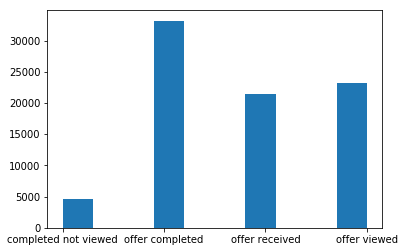

In [81]:
plt.hist(merge['event'])

([<matplotlib.patches.Wedge at 0x7f231e3d6128>,
 [Text(-1.04928,0.330162,'Offer Completed'),
  Text(0.300057,-1.05828,'Offer Viewed'),
  Text(1.01034,0.434995,'Offer Received'),
  Text(0.191052,1.08328,'Completed not Viewed')],
 [Text(-0.572336,0.180088,'40.3%'),
  Text(0.163667,-0.577246,'28.2%'),
  Text(0.551092,0.23727,'25.9%'),
  Text(0.10421,0.590881,'5.6%')])

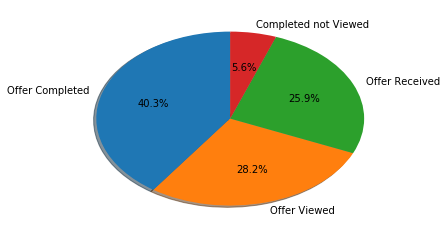

In [82]:
from matplotlib.pyplot import pie, axis, show
count = merge['event'].value_counts()
labels = 'Offer Completed', 'Offer Viewed', 'Offer Received', 'Completed not Viewed'
pie( count, autopct='%1.1f%%', shadow=True, startangle=90,  labels=labels)


([<matplotlib.patches.Wedge at 0x7f231e37eb70>,
 [Text(-1.0139,0.426622,'Offer Completed'),
  Text(0.348891,-1.0432,'Offer Viewed'),
  Text(0.938035,0.574535,'Offer Received'),
  Text(0.187706,1.08387,'Completed not Viewed')],
 [Text(-0.553037,0.232703,'37.3%'),
  Text(0.190304,-0.56902,'35.6%'),
  Text(0.511655,0.313383,'21.6%'),
  Text(0.102385,0.5912,'5.5%')])

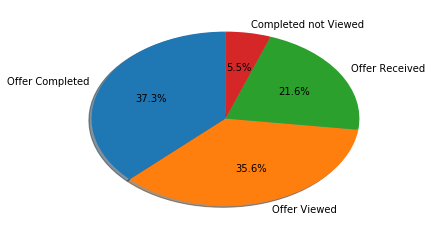

In [83]:
bogo =  merge['offer_type']=='bogo'
bogo = merge[bogo]
count = bogo['event'].value_counts()
pie( count, autopct='%1.1f%%', shadow=True, startangle=90,  labels=labels)

([<matplotlib.patches.Wedge at 0x7f231e3ab748>,
 [Text(-1.04818,0.333645,'Offer Completed'),
  Text(0.26546,-1.06749,'Offer Viewed'),
  Text(1.05732,0.303438,'Offer Received'),
  Text(0.295975,1.05943,'Completed not Viewed')],
 [Text(-0.571734,0.181988,'40.2%'),
  Text(0.144796,-0.582266,'27.4%'),
  Text(0.57672,0.165511,'23.8%'),
  Text(0.161441,0.577873,'8.7%')])

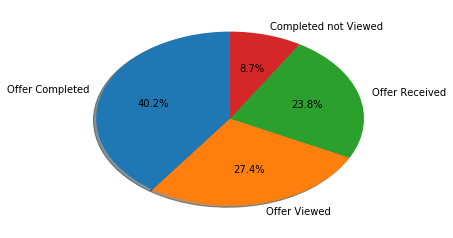

In [84]:
discount =  merge['offer_type']=='discount'
discount = merge[discount]
count = discount['event'].value_counts()
pie( count, autopct='%1.1f%%', shadow=True, startangle=90,  labels=labels)

([<matplotlib.patches.Wedge at 0x7f231e357908>,
 [Text(-1.09133,0.137812,'Offer Completed'),
  Text(0.737244,-0.816377,'Offer Viewed'),
  Text(0.71758,0.833714,'Offer Received')],
 [Text(-0.595273,0.0751701,'46.0%'),
  Text(0.402133,-0.445296,'31.4%'),
  Text(0.391407,0.454753,'22.6%')])

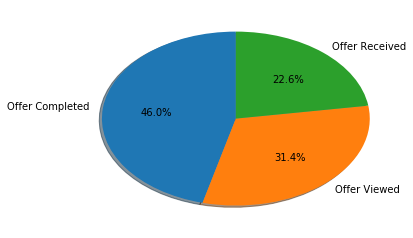

In [85]:
informational =  merge['offer_type']=='informational'
informational = merge[informational]
count = informational['event'].value_counts()
labels ='Offer Completed', 'Offer Viewed', 'Offer Received'
pie( count, autopct='%1.1f%%', shadow=True, startangle=90,  labels=labels)

(array([ 32482.,      0.,      0.,      0.,      0.,  32301.,      0.,
             0.,      0.,  17532.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

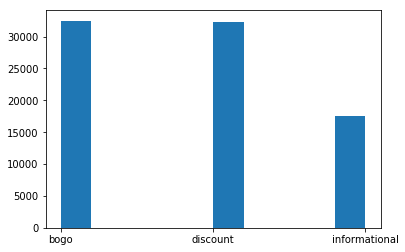

In [86]:
plt.hist(merge['offer_type'])

In [87]:
Sum = merge.groupby(['offer_type']).sum()
Sum['amount']


offer_type
bogo             284333.0
discount         308140.0
informational    105137.0
Name: amount, dtype: float64

In [88]:
Sum['reward_y']

offer_type
bogo             244420
discount          95399
informational         0
Name: reward_y, dtype: int64

In [89]:
Sum['amount']-Sum['reward_y']

offer_type
bogo              39913.0
discount         212741.0
informational    105137.0
dtype: float64

In [90]:
merge['amount'].sum()


697610.0

In [91]:
Avg_amount = merge.groupby(['offer_type']).sum()/merge.groupby(['offer_type']).count()
Avg_amount['amount']

offer_type
bogo             8.753556
discount         9.539643
informational    5.996863
Name: amount, dtype: float64

In [92]:
#Check for NaNs
print('Natrurally missing data points {}'.format(merge.isnull().sum()))

Natrurally missing data points amount              0
event               0
member id           0
offer_id            0
reward_x            0
time                0
concat              0
difficulty          0
duration            0
offer_type          0
reward_y            0
email               0
mobile              0
social              0
web                 0
age             10080
gender          10080
income          10080
member_years    10080
dtype: int64


In [93]:
#drop NaNs
merge =merge.dropna()

In [94]:
#Check for NaNs
print('Natrurally missing data points {}'.format(merge.isnull().sum()))

Natrurally missing data points amount          0
event           0
member id       0
offer_id        0
reward_x        0
time            0
concat          0
difficulty      0
duration        0
offer_type      0
reward_y        0
email           0
mobile          0
social          0
web             0
age             0
gender          0
income          0
member_years    0
dtype: int64


## Split data and begin training and testing

In [95]:
#get dummies on gender
merge = pd.get_dummies(merge, columns = ['gender'])
merge = pd.get_dummies(merge, columns = ['offer_type'])


#Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['time','amount','reward_x','difficulty', 'duration','reward_y','age','income','member_years']

features_log_minmax_transform = pd.DataFrame(data = merge)
features_log_minmax_transform[numerical] = scaler.fit_transform(merge[numerical])

In [96]:
#Calculate naive bias scores
event_raw = merge['event']
event = event_raw.apply(lambda x: 1 if x == "offer completed" else 0)

# Calculate accuracy, precision and recall
TP = np.sum(event)
FP = event.count() - TP
TN = 0
FN = 0
accuracy = float(TP)/(TP+FP)
recall = float(TP)/(TP+FN)
precision = float(TP)/(TP+FP)

#Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.5**2)*(precision*recall)/(0.5**2*precision+recall)

# Print the results 
print ("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.4326, F-score: 0.4880]


In [97]:
#create events and features dataframes
event = merge['event']
features_final = features_log_minmax_transform.drop('event', axis=1)
features_final = features_final.drop('member id', axis=1)
features_final = features_final.drop('offer_id', axis=1)
features_final = features_final.drop('time', axis=1)
features_final = features_final.drop('reward_x', axis=1)
features_final = features_final.drop('concat', axis=1)
features_final = features_final.drop('amount', axis=1)


from sklearn.cross_validation import train_test_split
# Split the 'features' and 'event' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    event, 
                                                    test_size = 0.2, 
                                                    random_state = 21)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 57788 samples.
Testing set has 14447 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [98]:
features_final.tail(10)

,difficulty,duration,reward_y,email,mobile,social,web,age,income,member_years,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
82305,0.25,0.571429,0.5,1,1,0,1,0.192771,0.044444,0.301152,0,1,0,1,0,0
82306,0.50,0.285714,1.0,1,1,1,1,0.277108,0.388889,0.133845,0,1,0,1,0,0
82307,0.25,0.285714,0.5,1,1,1,1,0.192771,0.044444,0.301152,0,1,0,1,0,0
82308,0.00,0.000000,0.0,1,1,1,0,0.530120,0.611111,0.444323,0,1,0,0,0,1
82309,1.00,1.000000,0.5,1,0,0,1,0.325301,0.355556,0.333516,1,0,0,0,1,0
82310,0.00,0.000000,0.0,1,1,1,0,0.481928,0.011111,0.520570,0,1,0,0,0,1
82311,0.50,0.571429,0.2,1,1,0,1,0.325301,0.355556,0.333516,1,0,0,0,1,0
82312,0.25,0.571429,0.5,1,1,0,1,0.325301,0.355556,0.333516,1,0,0,1,0,0
82313,1.00,1.000000,0.5,1,0,0,1,0.566265,0.911111,0.191991,1,0,0,0,1,0
82314,0.50,1.000000,0.2,1,1,1,1,0.325301,0.355556,0.333516,1,0,0,0,1,0


In [99]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
# Making predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.549975773517
The test accuracy is 0.518308299301


In [101]:
from sklearn import metrics
print(metrics.confusion_matrix(y_train, y_train_pred))

print(metrics.classification_report(y_train, y_train_pred, digits=3))

[[  571  1852  1064   102]
 [  176 19741  2226  2844]
 [  236  6776  5666  2115]
 [   37  6935  1643  5804]]
                      precision    recall  f1-score   support

completed not viewed      0.560     0.159     0.248      3589
     offer completed      0.559     0.790     0.655     24987
      offer received      0.535     0.383     0.446     14793
        offer viewed      0.534     0.403     0.459     14419

         avg / total      0.547     0.550     0.527     57788



In [102]:
from time import time
from IPython.display import display
from sklearn.metrics import fbeta_score, accuracy_score, log_loss, roc_auc_score,  f1_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: event training set
       - X_test: features testing set
       - y_test: event testing set
    '''
    
    results = {}
    
    #Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])

    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = f1_score(y_train[:300],predictions_train, average ='macro' )
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = f1_score(y_test,predictions_test, average ='macro')
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

RandomForestClassifier trained on 577 samples.
RandomForestClassifier trained on 5778 samples.
RandomForestClassifier trained on 57788 samples.
AdaBoostClassifier trained on 577 samples.
AdaBoostClassifier trained on 5778 samples.
AdaBoostClassifier trained on 57788 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 577 samples.
SVC trained on 5778 samples.
SVC trained on 57788 samples.


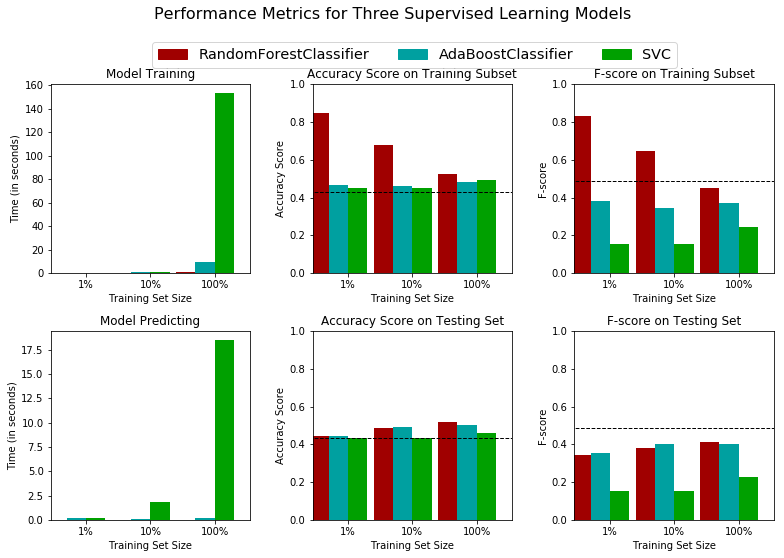

In [103]:
#Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import visuals  as vs

#Initialize the three models
clf_A = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5)
clf_B = AdaBoostClassifier(random_state = 21)
clf_C = SVC(kernel='poly', degree=4, C=0.1)

#Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(len(y_train)*10/100)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [104]:
#Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#Initialize the classifier
clf = RandomForestClassifier()

#Create the parameters list.
parameters = {'max_depth':[2,4,6,8,10],'min_samples_leaf':[2,4,6,8,10], 'min_samples_split':[2,4,6,8,10]}
#fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5,average ='macro')

#Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer, cv=3, n_jobs=2)

#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5, average ='macro')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5, average ='macro')))

/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/py

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:113

Unoptimized model
------
Accuracy score on testing data: 0.3931
F-score on testing data: 0.3357

Optimized Model
------
Final accuracy score on the testing data: 0.5157
Final F-score on the testing data: 0.4274


In [107]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

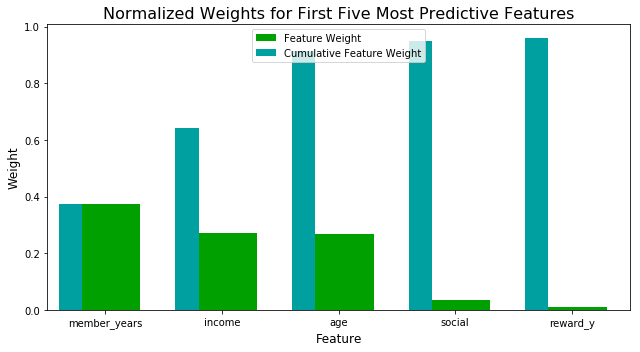

In [109]:
#Train the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier().fit(X_train, y_train)

#Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

Text(0.5,1,'RandomForest Estimated Feature Importance')

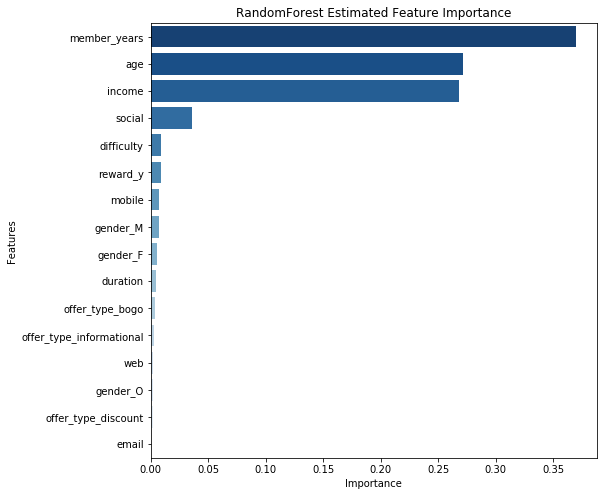

In [110]:
variable_names = features_final.columns[:]
model = RandomForestClassifier().fit(X_train, y_train)
relative_importance = model.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('RandomForest Estimated Feature Importance')

### Looks like the testing is scoring low.  I am going to change the event outcome to a binary class by switching two just "offer complete" and "not complete"

In [111]:
event = merge['event'].replace('offer viewed', 'offer not completed')
event = event.replace('offer received', 'offer not completed')
event = event.replace('completed not viewed', 'offer not completed')

event

0        offer not completed
1        offer not completed
2            offer completed
3            offer completed
4            offer completed
5        offer not completed
6            offer completed
7        offer not completed
9            offer completed
10           offer completed
11       offer not completed
12           offer completed
13       offer not completed
14       offer not completed
15       offer not completed
16       offer not completed
17           offer completed
18           offer completed
19           offer completed
20       offer not completed
21           offer completed
23           offer completed
24       offer not completed
25           offer completed
26       offer not completed
27           offer completed
28           offer completed
29       offer not completed
30       offer not completed
31           offer completed
                ...         
82284    offer not completed
82285        offer completed
82286        offer completed
82287        o

In [112]:

# Split the 'features' and 'event' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    event, 
                                                    test_size = 0.2, 
                                                    random_state = 21)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 57788 samples.
Testing set has 14447 samples.


RandomForestClassifier trained on 577 samples.
RandomForestClassifier trained on 5778 samples.
RandomForestClassifier trained on 57788 samples.
AdaBoostClassifier trained on 577 samples.
AdaBoostClassifier trained on 5778 samples.
AdaBoostClassifier trained on 57788 samples.


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC trained on 577 samples.
SVC trained on 5778 samples.
SVC trained on 57788 samples.


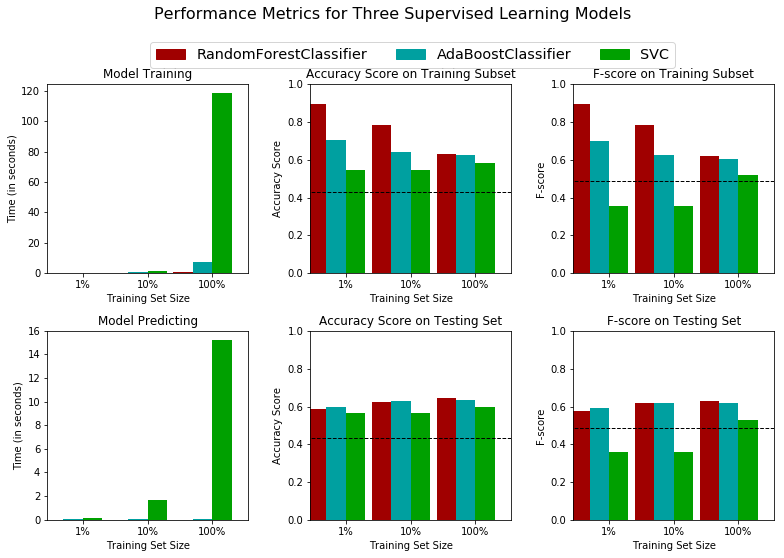

In [113]:
#Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
import visuals  as vs

#Initialize the three models
clf_A = RandomForestClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=5)
clf_B = AdaBoostClassifier(random_state = 21)
clf_C = SVC(kernel='poly', degree=4, C=0.1)

#Calculate the number of samples for 1%, 10%, and 100% of the training data

samples_100 = len(y_train)
samples_10 = int(len(y_train)*10/100)
samples_1 = int(len(y_train)/100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

In [121]:
#Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

#Initialize the classifier
clf = RandomForestClassifier()

#Create the parameters list.
parameters = {'max_depth':[6,8,10,12,14],'min_samples_leaf':[1,2,4,6,8], 'min_samples_split':[6,8,10,12,14]}
#fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5,average ='macro')

#Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters, scorer, cv=3, n_jobs=2)

#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5, average ='macro')))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5, average ='macro')))

Unoptimized model
------
Accuracy score on testing data: 0.5889
F-score on testing data: 0.5790

Optimized Model
------
Final accuracy score on the testing data: 0.6446
Final F-score on the testing data: 0.6326


In [122]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=12,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Text(0.5,1,'RandomForest Estimated Feature Importance')

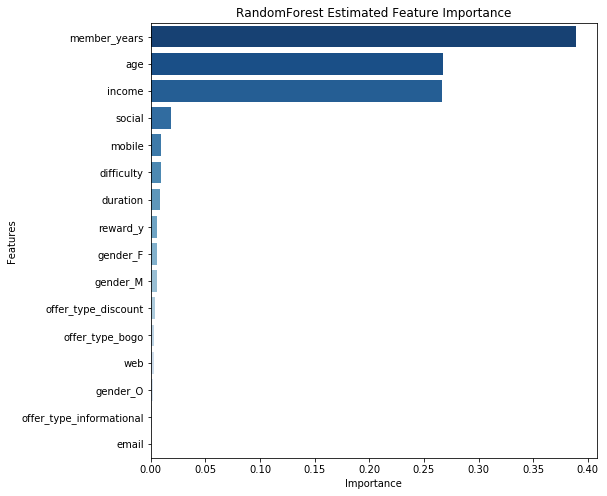

In [115]:
variable_names = features_final.columns[:]
model = RandomForestClassifier().fit(X_train, y_train)
relative_importance = model.feature_importances_
relative_importance = relative_importance / np.sum(relative_importance)

feature_importance =\
    pd.DataFrame(list(zip(variable_names,
                          relative_importance)),
                 columns=['feature', 'relativeimportance'])

feature_importance = feature_importance.sort_values('relativeimportance',
                                                    ascending=False)

feature_importance = feature_importance.reset_index(drop=True)

palette = sns.color_palette("Blues_r", feature_importance.shape[0])

plt.figure(figsize=(8, 8))
sns.barplot(x='relativeimportance',
            y='feature',
            data=feature_importance,
            palette=palette)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('RandomForest Estimated Feature Importance')